In [25]:
#data cleaning, importing, etc
#note: this dataset csv is close to 3gb in size. it may take well over a minute to load.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LogNorm
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.DataFrame()
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
except ImportError:
    print("kagglehub not found. Run pip install kagglehub in your terminal")
try:
    print("Downloading dataset from Kaggle...")
    folder = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
    df = pd.read_csv(folder + "/US_Accidents_March23.csv", encoding="latin1", low_memory=False)
    print("Dataset loaded successfully.")
except Exception as e:
    print("KaggleHub download failed:", e)
    
    
# first, drop columns with >50% missing data

df = df.dropna(axis=1, thresh=len(df) / 2)

# next datetime stuff

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.day_name()


rows_with_nans = df.isnull().any(axis=1).sum()
print("Rows with missing values before cleaning:", rows_with_nans)

# next just fill numeric columns with median fales
count = 0
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
        count += 1

# then for NaNs in categorical items just do mode
categorical_cols = df.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
        count += 1



print("Total rows:", len(df))
print("Total columns:", len(df.columns))
print("Any NaNs left?", df.isnull().sum().sum() > 0)   

 

Dataset loaded successfully.
Rows with missing values before cleaning: 4864129
Total rows: 7728394
Total columns: 50
Any NaNs left? False


BASIC STRUCTURE
Shape: (7728394, 50)
Number of features: 50
Number of entries: 7728394
Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year', 'Month', 'Hour', 'Weekday']


UNIQUE VALUE COUNTS (lowest 15)
Country           1
Turning_Loop      1
Amenity           2
Bump              2
Civil_Twilight    2
Sunrise_Sunset    2
Traffic_Signal    2
Crossing          2
Railway           2
Stop

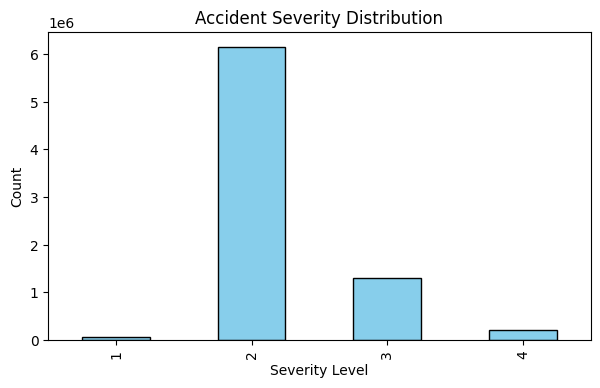

Accidents per Year:
Year
2016.00     410821
2017.00     717290
2018.00     893426
2019.00     954302
2020.00    1904764
2021.00    1412433
2022.00    1268806
2023.00     166552
Name: count, dtype: int64


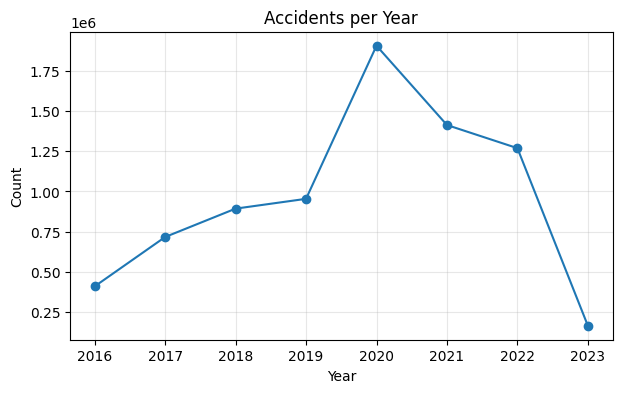

In [26]:

print("BASIC STRUCTURE")
print(f"Shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of entries: {df.shape[0]}")
print("Columns:", list(df.columns))
print("\n")

print("UNIQUE VALUE COUNTS (lowest 15)")
print(df.nunique().sort_values().head(15))
print("\n")

print("TOP STATES BY ACCIDENT COUNT")
print(df['State'].value_counts().head(10))
print("\n")

print("DISTRIBUTION OF SEVERITY")
print(df['Severity'].value_counts(normalize=True).sort_index() * 100)
plt.figure(figsize=(7,4))
df['Severity'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Accident Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.show()

print("Accidents per Year:")
print(df['Year'].value_counts().sort_index())
plt.figure(figsize=(7,4))
df['Year'].value_counts().sort_index().plot(marker='o')
plt.title('Accidents per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()


Contingency table:
Sunrise_Sunset      Day    Night
Severe                          
0               4302278  1922069
1               1055521   448526

Chi Squared =  638.277, p =  7.9177e-141, dof = 1
Expected frequencies:
Sunrise_Sunset        Day      Night
Severe                              
0              4315100.93 1909246.07
1              1042698.07  461348.93


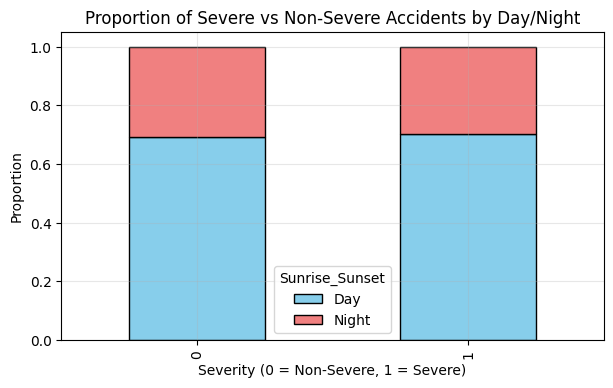

In [27]:
# Chi Squared Test
# Severity vs Day/Night
# Is the severity of accident independent of daylight?


df['Severe'] = (df['Severity'] >= 3).astype(int) # note the dataset ranks severity 1-4

table = pd.crosstab(df['Severe'], df['Sunrise_Sunset'])
chi2, p, dof, expected = stats.chi2_contingency(table)

print("Contingency table:")
print(table)
print(f"\nChi Squared = {chi2: .3f}, p = {p: .4e}, dof = {dof}")
print("Expected frequencies:")
print(pd.DataFrame(expected, index=table.index, columns=table.columns))

proportions = (table.T / table.T.sum()).T

proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(7,4),
    color=['skyblue', 'lightcoral'],
    edgecolor='black'
)

plt.title('Proportion of Severe vs Non-Severe Accidents by Day/Night')
plt.xlabel('Severity (0 = Non-Severe, 1 = Severe)')
plt.ylabel('Proportion')
plt.legend(title='Sunrise_Sunset')
plt.grid(alpha=0.3)
plt.show()

The test produced a chi squared of 638.28 with 1 degree of freedom and p = 7.9 * 10^(-141).

Since p < 0.05, we reject the null hypothesis that accident severity is independent of daylight conditions. There is a statistically significant relationship between time of day and accident severity.

Although both daytime and nighttime have large numbers of accidents, the proportion of severe accidents is slightly higher during the day than it would be if evenly distributed.

This could be a reflection of the much greater volume of daytime traffic. More vehicles on the road increases the probability of high-impact collisions even though (generally) driving conditions are better. With more cars on the road, there are more things to hit.

The stacked bar chart shows the proportions of severe vs non-severe accidents. While the percentage seems relatively small, the datasets size of over 7 million collisions makes this pattern statistically meaningful.



Trimmed visibility outside [0.5, 10.0] mi — removed 81,838 rows.
Pearson correlation:  r = -0.0136, p-value = 5.594e-311
Spearman correlation: r = -0.0152, p-value = 0.000e+00


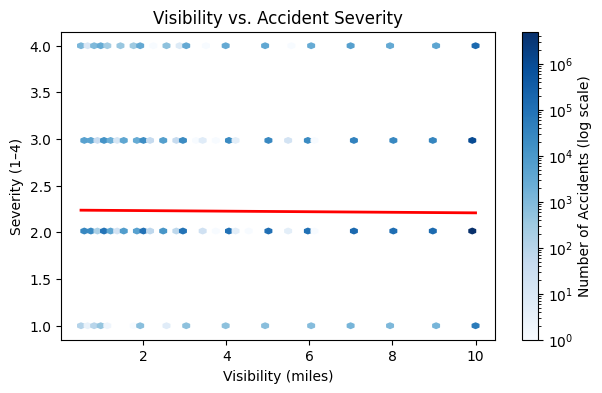

In [30]:
# Correlation analysis between visibility and accident severity

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
corr_df = df[['Visibility(mi)', 'Severity']].dropna().copy()
corr_df['Severity'] = pd.to_numeric(corr_df['Severity'], errors='coerce')
corr_df = corr_df.dropna()

lo, hi = corr_df['Visibility(mi)'].quantile([0.01, 0.99])
trim = corr_df[(corr_df['Visibility(mi)'] >= lo) & (corr_df['Visibility(mi)'] <= hi)]
removed = len(corr_df) - len(trim)
print(f"Trimmed visibility outside [{lo:.1f}, {hi:.1f}] mi — removed {removed:,} rows.")

pearson_r, pearson_p = pearsonr(trim['Visibility(mi)'], trim['Severity'])
spearman_r, spearman_p = spearmanr(trim['Visibility(mi)'], trim['Severity'])

print(f"Pearson correlation:  r = {pearson_r:.4f}, p-value = {pearson_p:.3e}")
print(f"Spearman correlation: r = {spearman_r:.4f}, p-value = {spearman_p:.3e}")

plt.figure(figsize=(7,4))
hb = plt.hexbin(trim['Visibility(mi)'], trim['Severity'], gridsize=60, cmap='Blues', norm=LogNorm(), mincnt=1)
plt.colorbar(label='Number of Accidents (log scale)')
plt.xlabel('Visibility (miles)')
plt.ylabel('Severity (1–4)')
plt.title('Visibility vs. Accident Severity')

x = trim['Visibility(mi)'].to_numpy()
y = trim['Severity'].to_numpy()
b1, b0 = np.polyfit(x, y, 1)
xline = np.linspace(x.min(), x.max(), 100)
plt.plot(xline, b1 * xline + b0, color='red', linewidth=2)
plt.show()


CA vs TX
CA: 285,316/1,741,433 = 16.38% severe
TX: 127,652/582,837 = 21.90% severe
Difference: -5.52%
z = -95.39, p = 0.000e+00


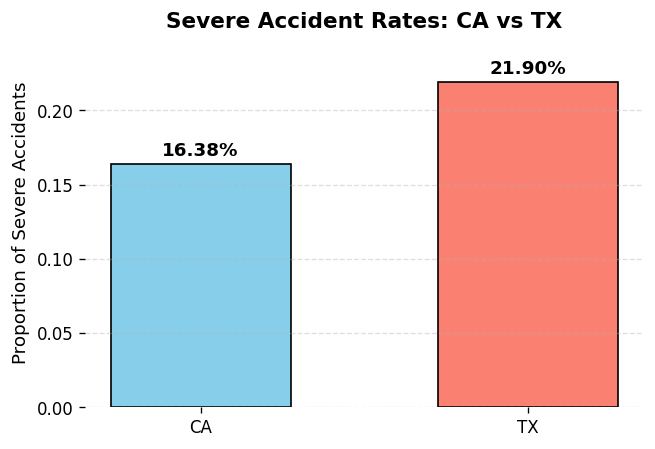

In [29]:
# hypothesis test of severity of accidents between California and Texas
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import numpy as np

def compare_state_severity(df, state_a='CA', state_b='TX'):
    df['Severe'] = (df['Severity'] >= 3).astype(int)

    # severe accidents
    counts = np.array([
        df.query("State == @state_a")['Severe'].sum(),
        df.query("State == @state_b")['Severe'].sum()
    ])
    
    # total accidents
    nobs = np.array([
        len(df.query("State == @state_a")),
        len(df.query("State == @state_b"))
    ])

    p1, p2 = counts[0]/nobs[0], counts[1]/nobs[1]
    z, p = proportions_ztest(counts, nobs)

    print(f"{state_a} vs {state_b}")
    print(f"{state_a}: {counts[0]:,}/{nobs[0]:,} = {p1*100:.2f}% severe")
    print(f"{state_b}: {counts[1]:,}/{nobs[1]:,} = {p2*100:.2f}% severe")
    print(f"Difference: {(p1 - p2)*100:.2f}%")
    print(f"z = {z:.2f}, p = {p:.3e}")



    plt.figure(figsize=(6,4), dpi=120)
    bars = plt.bar([state_a, state_b], [p1, p2],
                   color=['skyblue','salmon'], edgecolor='black', width=0.55)

    for i, v in enumerate([p1, p2]):
        plt.text(i, v + 0.003, f"{v*100:.2f}%", ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    plt.ylim(0, max(p1,p2)+0.03)
    plt.ylabel("Proportion of Severe Accidents", fontsize=11)
    plt.title(f"Severe Accident Rates: {state_a} vs {state_b}", fontsize=13, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.box(False)
    plt.show()

compare_state_severity(df, 'CA', 'TX')


To test whether the proportion of severe accidents (severity >= 3) differs between California and Texas, a two-proportion z-test was performed.

The p-value is far below .05 so we reject the null hypothesis that both states have equal rates of severe accidents. Statistically, Texas has a significantly higher proportion of severe accidents than California. 

This difference in proportions between states could be due to a number of reasons. Speed and vehicle size both play a part in the severity of vehicle accidents, and Texas 'outdoes' California in both of those categories. Texan roads and highways generally have higher standard speed limits, with speed limits of up to 85 mile-per-hour on highways, and up to 75 mile-per-hour speed limits on two-lane undivided roadways (which are a type of road particularly prone to severe accidents). In contrast, Californian highways usually top out at around 65 miles-per-hour, with a maximum of around 55 miles-per-hour on undivided two-land roads. In terms of vehicle size, Texan roads are generally home to a higher number of pickups and SUVs; whose larger sizes increase the risk of injury to the occupants of the vehicles they crash with, as per the IIHS. In Texan cities like Houston, SUV/Light Truck sales were about four times more than regular car sales, while in Calfornia, these larger vehicles were only sold at around twice the rate of regular cars.

We can use some of the variables in our dataset to investigate the possibility of road type being a factor in these accidents; we can look through the accident description variable for indicators of highway involvement (ie. I-##, Hwy-##, Highway ##), and use variables like 'crossing', 'traffic stop', and 'junction' to gain further insights if the accident was on regular roads and not highways. However, as the variables in our dataset contain mostly information about the environment and situation of the accidents, and not the vehicles themselves, it may be difficult to gain insights on vehicle speeds playing a part in accident severity, or to investigate the second possible explanation (regarding vehicle size).

Sources:
https://www.hsinjurylaw.com/library/the-dangers-of-two-lane-highways.cfm#:~:text=Unlike%20larger%20highways%2C%20two%2Dlane,one%20side%20from%20the%20other.
https://www.iihs.org/research-areas/speed/speed-limit-laws
https://www.iihs.org/news/detail/supersizing-vehicles-offers-minimal-safety-benefits--but-substantial-dangers
https://www.cncda.org/wp-content/uploads/Cal-Covering-2Q-23_FINAL.pdf
https://www.houston.org/houston-data/monthly-update-vehicle-sales/